# Algorytm ROCKET w wersji dla szeregów czasowych wielu zmiennych **cz. I**





**Autorzy: Mariola Bartosik & Krystian Okręglicki**


## Wprowadzenie

Algorytm ROCKET przekształca szeregi czasowe wykorzystując losowe jądra splotowe stosowane w sieciach neuronowych. 
Szereg czasowy to ciąg obserwacji pokazujący kształtowanie sie badanego zjawiska. 
\
 W naszym projekcie będziemy pracować na wielowymiarowych szereach przekrojowych, są to zbiory stanów $m$ zmiennych
$Y_1, Y_2, ...., Y_m,$ z których każdy odnosi się do tego samego momentu lub okresu $t$
i do innego $j$‑tego obiektu $(j = 1, 2,..., k)$, charakteryzujących zjawisko (stan obiektu). \
Algorytm ROCKET użyty do klasyfikacji szeregów z wykorzystaniem prostego klasyfikatora liniowego ma małą złożoność obliczeniową. 
Główną charakterystyką tego algorytmu jest wykorzystanie (domyślnie) 10000 jąder, które mają następujące własności 


*   długość wybieramy ze zbioru $\{7,9,11\}$
*   wagę ustalamy ze standardowego rozkładu normalnego 
*  bias ustalamy z rozkładu jednostajnego na odcinku $(-1,1)$
* dilation jest próbkowana z skali wykładniczej $2^x$ gdzie $x$ jest z rozkladu jednostajnego z przedziału $(0,A)$. Natomiast $A=\log_2 \frac{l_{input-1}}{l_{kernel-1}}$
* padding (stosujemy lub nie) wypełnienie zerami początku i końca szeregu

Zauważmy, że
parametry wag i obciążenia zostaną ustalone w przedstawiony sposób biorąc pod uwagę, że wejściowe szeregi czasowe będa znormalizowane, czyli będą miały 
średnią równą $0$ i odchylenie standardowe równe $1$.




## Implementacja

Zaimplementujemy algorytm dla szeregów wielowymiarowych.
Zaczniemy od konstrukcji funkcji generującej losowe jądra. Funkcją generującą jądra będzie generate_kernels. Dzięki niej będziemy mogli w wygodny sposób stworzyć wszytskie parametry potrzebne do zaakplikowania jąder splotowych.

Następnie do każdego jądra zastosujemy każdy wejściowy szereg czasowy tworząc mapę cech. Do tego wykorzystamy funkcję *apply_kernels* lub *apply_kernels_fast*. Ich wyniki, czyli macierze przekształceń są identyczne, ale w związku z chęcią przyśpieszenia działania algorytmu powstała wersja *fast*, która wykorzystuje równoległe wykonywanie pętli, co pozwala nam na nawet czterokrotne zmniejszenie czasu. Funkcje ta będzie korzystać z dwoch dodatkowych funkcji *apply_kernel_univariate* oraz *apply_kernel_multiivariate*, które będą działać na szeregach w zależności od typu przetwarzanego w danej chwili szeregu. \


Wynik użycia jądra $\omega$, z dilitation $d$ do  danego szeregu czasowego $X$ dla pozycji $X_i$ jest dany poprzez
$$ X_i \cdot \omega=\sum_{j=0}^{l_{kernel}-1}  X_{i+(j\times d)}\times \omega_j  $$

 ROCKET obliczy 2 cechy z każdej mapy. Zatem dla $ k$ jąder, ROCKET stworzy $2k$ cech.



 Cechami są
* maksymalna wartość
* ppv - odsetek pozytywnie sklasyfikowanych przypadków, które były naprawdę pozytywne

Przekształcone cechy są używane do trenowania.

Następnie użyjemy regresji grzbietowej.

## Klasyfikacja

W naszych zbiorach danych częstym przypadkiem jest występowanie więcej niż jednej klasy/targetu. Podejdziemy więc do problemu klasyfikacji stosując metodę korzystajacą z regresji grzbietowej. Będziemy budujować model dla każdej klasy osobno, zamieniając przy tym inne klasy na -1, a tą konkretną na 1. W każdym przypadku będziemy szukać najlepszej wartości $\lambda$ używając cross-walidacji.  Następnie używając tych modeli stworzymy macierz, z której dla każdego szeregu wybierzemy indeks kolumny, w której jest największa wartość. Jest to znany sposób na klasyfikację z wykorzystaniem regresji. 

## Badania i Wyniki

Zbiory danych pochodzą ze strony *http://www.timeseriesclassification.com/dataset.php*. W tym raporcie przeanalizujemy klasyfikację czterowymiarowego zbioru  **ERing**. 

Zacznijmy od załadowania potrzebnych bibliotek.



In [ ]:
#potrzebne biblioteki
library(tictoc)
library(foreach)
library(doParallel)
library(foreign)
library(glmnet)

Po pierwsze należy wywołać wszystkie funkcje z pliku *Rocket_funkcje_ostateczna*. Następnie należy wczytać dane i zapisać jako listy zmiennych w sposób przedstawiony poniżej. 

In [ ]:
#wczytanie danych i zapisanie jako dwie listy: 
#X- ramek danych treningowych, Y- ramek danych testowych

Mw <- read.arff(file="ERingDimension1_TRAIN.arff")
Mx <- read.arff(file="ERingDimension2_TRAIN.arff")
My <- read.arff(file="ERingDimension3_TRAIN.arff")
Mz <- read.arff(file="ERingDimension4_TRAIN.arff")

Tw <- read.arff(file="ERingDimension1_TEST.arff")
Tx <- read.arff(file="ERingDimension2_TEST.arff")
Ty <- read.arff(file="ERingDimension3_TEST.arff")
Tz <- read.arff(file="ERingDimension4_TEST.arff")
 
X <- list(Mw, Mx, My, Mz) #lista ramek danych treningowych
Y <- list(Tw, Tx, Ty, Tz) #lista ramek danych testowych


Jeśli klasy są w pierwszej kolumnie należy użyć do list następujących funkcji. Jeśli klasy są w ostaniej kolumnie należy pominąć ten krok.

In [ ]:
#X lista danych treningowych
#Y lista danych testowych
X <-zmiana_klas(X)
Y <-zmiana_klas(Y)

Następnie aby uzyskać wyniki dla 10 prób na danym zbiorze wywołujemy *dokladnosc_(X,Y)*. Zakładamy, że każda ramka danych ze zbioru danych ma klasę/target w ostatnich kolumnach. Jeśli klasy są liczbami, nie trzeba podawac więcej argumentów, jeśli klasy są napisami, należy dodać argument *typ_klasy=1* (tzn. *dokladnosc_(X, Y, typ_klasy=1)*. Domyślnie przyjmujemy $1000$ kerneli, jeśli chcemy zmienić liczbę wystarczy dodać argument *liczba_ker*, np. *dokladnosc_(X, Y, liczba_ker=55, typ_klasy=1)*

In [ ]:
dokladnosc_(X, Y, liczba_ker=55, typ_klasy=1)

###WYNIKI

Wygenerujemy macierze przedstawiające dla 100 i 1000 kerneli dokładność klasyfikacji dla 10 doświadczeń. Dokładność jest wartością z przedziału $[0,1]$ dla danych ze zbioru. Liczona jest przy użyciu wzoru $$\frac{\text{liczba wszystkich dobrze sklasifikowanych obserwacji}}{\text{liczba wszystkich klasyfikowanych obserwacji}}$$ W przedostatniem wierszu podamy średnią, natomiast w ostatnim wariancję. Widzimy z tabelki, że uzyskane dla $1000$ kerneli wyniki są z przedziału $(94\%,97\%)$. Bardzo dobre wyniki otrzymujemy także przy wykorzystaniu tylko 100 kerneli. Wyniki potwierdzają skuteczność algorytmu ROCKET.




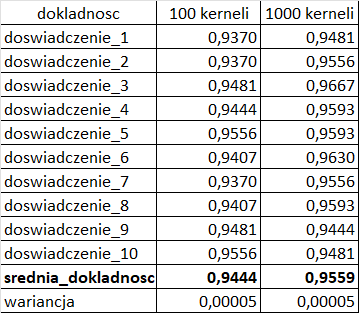

Dodatkowo przeprowadzimy badania na innych równych zbiorach i porównamy wyniki z uzyskanymi na przyciętych danych. 
Przycinanie wykonanamy dla każdej z klasy z osobna oraz osobno dla plików train i test. Wówczas w każdej klasie przycinanie będzie według tego samego algorytmu.
Przyjmiemy, że dla każdej klasy 1/3 instancji będzie miała długość z przedziału [10%,40%] oryginalnej długości, 1/3 instancji będzie miała długości (40%,70%] oryginalnej długości,  a pozostała część (70%,100%]. 

Następnie wszystkie eksperymenty powtórzymy 10 razy i wyniki uśrednimy.
Wyniki zaprezentujemy w drugim raporcie.